In [1]:
# required packages: countdown-timer pyserial numpy av

In [2]:
#from llpyspin import secondary, primary
import numpy as np
import matplotlib.pyplot as plt
import os, time, serial, glob, struct

def packIntAsLong(value):
    """Packs a python 4 byte integer to an arduino long"""
    return struct.pack('i', value)


def plot_timeline(num_cycles, exposure_time, inv_framerate,
                 phase_shift, UV_duration, UV_delay):
    
    (
        NIR_top_on,
        NIR_top_off,
        NIR_bottom_on,
        NIR_bottom_off,
        UVA_top_on,
        UVA_top_off,
        post_UVA_top_trigger_on,
        post_UVA_top_trigger_off,
        UVA_bottom_on,
        UVA_bottom_off,
        post_UVA_bottom_trigger_on,
        post_UVA_bottom_trigger_off
    ) = get_timeline(
        num_cycles, exposure_time, inv_framerate,
        phase_shift, UV_duration, UV_delay)
        
    
    OFFSET = 1.5
    fig,axs = plt.subplots(2,1,sharex=True)

    UVA_top_trace = np.zeros(2*inv_framerate)
    UVA_top_trace[UVA_top_on:UVA_top_off] = 1
    UVA_top_trace = np.roll(np.tile(UVA_top_trace,2), inv_framerate)
    
    UVA_bottom_trace = np.zeros(2*inv_framerate)
    UVA_bottom_trace[UVA_bottom_on:UVA_bottom_off] = 1
    UVA_bottom_trace = np.roll(np.tile(UVA_bottom_trace,2), inv_framerate)

    NIR_top_trace = np.zeros(2*inv_framerate)
    NIR_top_trace[NIR_top_on:NIR_top_off] = 1
    NIR_top_trace = np.roll(np.tile(NIR_top_trace,2), inv_framerate)

    NIR_bottom_trace = np.zeros(2*inv_framerate)
    NIR_bottom_trace[NIR_bottom_on:NIR_bottom_off] = 1
    NIR_bottom_trace = np.roll(np.tile(NIR_bottom_trace,2), inv_framerate)
    
    trigger_top_trace = np.zeros(2*inv_framerate) 
    trigger_top_trace[post_UVA_top_trigger_on:post_UVA_top_trigger_off] = 1
    trigger_top_trace[NIR_top_on:NIR_top_off] = 1
    trigger_top_trace = np.roll(np.tile(trigger_top_trace,2), inv_framerate)

    trigger_bottom_trace = np.zeros(2*inv_framerate) 
    trigger_bottom_trace[post_UVA_bottom_trigger_on:post_UVA_bottom_trigger_off] = 1
    trigger_bottom_trace[NIR_bottom_on:NIR_bottom_off] = 1
    trigger_bottom_trace = np.roll(np.tile(trigger_bottom_trace,2), inv_framerate)

    
    axs[0].plot(UVA_top_trace+OFFSET, c='violet', linewidth=2, label='UV-A')
    axs[1].plot(UVA_bottom_trace+OFFSET, c='violet', linewidth=2, label='UV-A')
        
    axs[0].plot(NIR_top_trace+OFFSET*2, c='red', linewidth=2, label='NIR')
    axs[1].plot(NIR_bottom_trace+OFFSET*2, c='red', linewidth=2, label='NIR')
    
    axs[0].plot(trigger_top_trace, c='black', linewidth=2, label='Trigger')
    axs[1].plot(trigger_bottom_trace, c='black', linewidth=2, label='Trigger')
    
    axs[0].set_ylabel('Top')
    axs[1].set_ylabel('Bottom')
    
    for ax in axs:
        ax.set_yticks([])
        ax.legend(loc='upper right')
        ax.axvline(x = inv_framerate, linestyle= 'dashed', c='gray')
        ax.axvline(x = inv_framerate*3, linestyle= 'dashed', c='gray')
        
    axs[-1].set_xticks(np.arange(inv_framerate,3*inv_framerate+1,1000))
    axs[-1].set_xticklabels(np.arange(0,(2*inv_framerate+1)/1000))
    axs[-1].set_xlabel('ms')
    axs[-1].set_xlim([0,inv_framerate*4])
    fig.set_size_inches((13,4))
    
    
def get_timeline(num_cycles, exposure_time, inv_framerate,
                 phase_shift, UV_duration, UV_delay):
    
    NIR_top_on  = 0;
    NIR_top_off = exposure_time;

    UVA_top_on  = inv_framerate - UV_delay - UV_duration ;
    UVA_top_off = inv_framerate - UV_delay;

    post_UVA_top_trigger_on  = inv_framerate;
    post_UVA_top_trigger_off = inv_framerate + exposure_time;

    NIR_bottom_on  = phase_shift;
    NIR_bottom_off = phase_shift + exposure_time;

    UVA_bottom_on  = phase_shift + inv_framerate - UV_delay - UV_duration ;
    UVA_bottom_off = phase_shift + inv_framerate - UV_delay;

    post_UVA_bottom_trigger_on  = phase_shift + inv_framerate;
    post_UVA_bottom_trigger_off = phase_shift + inv_framerate + exposure_time;

    return (
        NIR_top_on,
        NIR_top_off,
        NIR_bottom_on,
        NIR_bottom_off,
        UVA_top_on,
        UVA_top_off,
        post_UVA_top_trigger_on,
        post_UVA_top_trigger_off,
        UVA_bottom_on,
        UVA_bottom_off,
        post_UVA_bottom_trigger_on,
        post_UVA_bottom_trigger_off)

    
def check_timeline(*params):
    timeline = np.array(get_timeline(*params))
    assert (timeline[:-1] <= timeline[1:]).all(), 'Timing is invalid'

    
def get_timing_params(duration, framerate, exposure_time, 
                      UV_duration=1000, UV_delay=50, buffer=50):
    
    inv_framerate = int(1e6/framerate)
    phase_shift = exposure_time + UV_duration + UV_delay + buffer
    num_cycles = int(duration * framerate / 2)
    
    params = (
        num_cycles,
        exposure_time,
        inv_framerate,
        phase_shift,
        UV_duration,
        UV_delay
    )
    
    check_timeline(*params)
    plot_timeline(*params)
    return params
    

In [ ]:
#num_cycles = number of on off cycles
#exposure_time = duration of exposure
#inv_framerate,
#phase_shift,
#UV_duration,
#UV_delay

In [3]:
import numpy as np
import subprocess
import datetime
import multiprocessing as mp
import sys, time
sys.path.append('simple_pyspin/')
from simple_pyspin import Camera
import PySpin
from countdown import countdown
import av

In [4]:
def count_frames(file_name):
    with av.open(file_name, 'r') as reader:
        return reader.streams.video[0].frames


                
def write_frames(filename, frames, 
                 threads=6, fps=30, crf=10,
                 pixel_format='gray8', codec='ffv1',
                 pipe=None, slices=24, slicecrc=1):
    
    frame_size = '{0:d}x{1:d}'.format(frames.shape[2], frames.shape[1])
    command = ['ffmpeg',
               '-y',
               '-loglevel', 'fatal',
               '-framerate', str(fps),
               '-f', 'rawvideo',
               '-s', frame_size,
               '-pix_fmt', pixel_format,
               '-i', '-',
               '-an',
               '-crf',str(crf),
               '-vcodec', codec,
               '-preset', 'ultrafast',
               '-threads', str(threads),
               '-slices', str(slices),
               '-slicecrc', str(slicecrc),
               '-r', str(fps),
               filename]

    if not pipe: pipe = subprocess.Popen(command, stdin=subprocess.PIPE, stderr=subprocess.PIPE)
    dtype = np.uint16 if pixel_format.startswith('gray16') else np.uint8
    for i in range(frames.shape[0]): pipe.stdin.write(frames[i,:,:].astype(dtype).tobytes())
    return pipe



def get_camera(serial_number=None, exposure_time=2000, gain=15):
    
    cam = Camera(index=str(serial_number))
    cam.init()
    
    cam.GainAuto = 'Off'
    cam.Gain = gain
    cam.ExposureAuto = 'Off'
    cam.ExposureTime = exposure_time
    cam.AcquisitionMode = 'Continuous'
    
    cam.AcquisitionFrameRateEnable = True
    max_fps = cam.get_info('AcquisitionFrameRate')['max']
    cam.AcquisitionFrameRate = max_fps
    
    cam.TriggerMode = 'Off'
    cam.TriggerSource = 'Line3'
    cam.TriggerOverlap = 'ReadOut'
    cam.TriggerSelector = 'FrameStart'
    cam.TriggerActivation = 'RisingEdge'
    cam.TriggerMode = 'On'
    
    return cam


   
        
class AcquisitionLoop(mp.Process):
    
    def __init__(self, write_queue, **camera_params):
        super().__init__()

        self.ready = mp.Event()
        self.primed = mp.Event()
        self.stopped = mp.Event()
        self.write_queue = write_queue
        self.camera_params = camera_params

    def stop(self):
        self.stopped.set()
        
    def prime(self):
        self.ready.clear()
        self.primed.set()
        
    def run(self):
        try:
            cam = get_camera(**self.camera_params) 
        except:
            print(f'Failed to get camera {self.camera_params["serial_number"]}')
            
        self.ready.set()
        self.primed.wait()
        
        cam.start()
        self.ready.set()
        
        while not self.stopped.is_set():
            try: 
                frame = cam.get_array(timeout=1000)
                self.write_queue.put(frame)
            except PySpin.SpinnakerException: 
                pass 

        self.write_queue.put(tuple())
        if cam is not None: cam.close()
            
        
        

class Writer(mp.Process):
    
    def __init__(self, queue, file_name, **ffmpeg_options):
        super().__init__()
        self.pipe = None
        self.queue = queue
        self.file_name = file_name
        self.ffmpeg_options = ffmpeg_options

    def run(self):  
        while True:
            data = self.queue.get()
            if len(data)==0: 
                break
            else: 
                self.append(data)
        self.close()
            
    def append(self, data):
        self.pipe = write_frames(
            self.file_name, data[None], 
            pipe=self.pipe, **self.ffmpeg_options)

    def close(self):
        if self.pipe is not None:
            self.pipe.stdin.close()


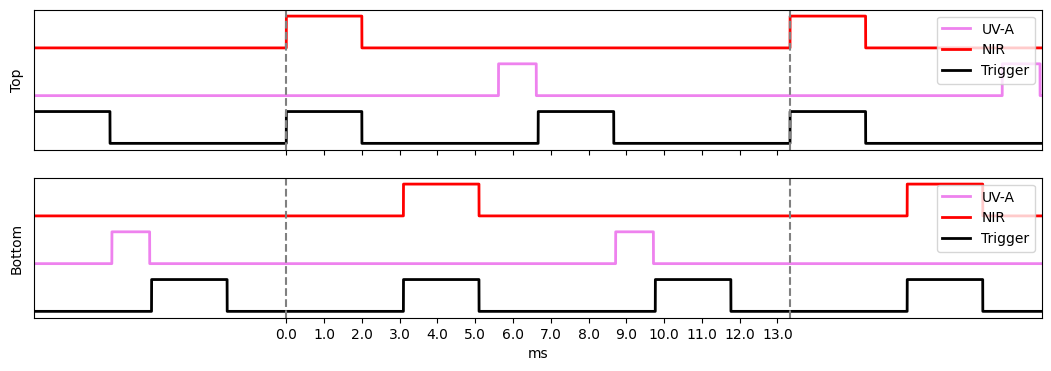

In [15]:
prefix = 'data/test'

duration = 3
framerate = 150
exposure_time = 2000

params = get_timing_params(duration, framerate, exposure_time)

In [ ]:
#num_cycles,
#exposure_time,
#inv_framerate,
#phase_shift,
#UV_duration,
#UV_delay

In [22]:
params

(225, 2000, 6666, 3100, 1000, 50)

In [6]:
serial_nums = {
   'top':    22181547,
   #'bottom': 22181541,
   'side1':  22181612,
   #'side2':  22181547,
   #'side3':  22181546,
   #'side4':  22181618
}


In [7]:
# initialize cameras
writers = []
acquisition_loops = []

for k,sn in serial_nums.items():

    write_queue = mp.Queue()
    
    writer = Writer(
        write_queue,
        f'{prefix}.{k}.avi',
        fps=framerate)
    
    acquisition_loop = AcquisitionLoop(
        write_queue, 
        serial_number=sn, 
        exposure_time=exposure_time,
        gain=15)
    
    writer.start()
    writers.append(writer)
    acquisition_loop.start()
    acquisition_loop.ready.wait()
    acquisition_loops.append(acquisition_loop)
    print(f'Initialized {k}')

Initialized top
Initialized side1


In [8]:
# prepare acquisition loops
for acquisition_loop in acquisition_loops:
    acquisition_loop.prime()
    acquisition_loop.ready.wait()

In [9]:
#`sudo chmod a+rw /dev/ttyACM0`

In [10]:
glob.glob('/dev/ttyACM*')

['/dev/ttyACM0']

In [11]:
port = glob.glob('/dev/ttyACM*')[0]
arduino = serial.Serial(port=port)

In [12]:
port

'/dev/ttyACM0'

In [13]:
msg = b''.join(map(packIntAsLong,params))
arduino.write(msg)

24

In [14]:
arduino

Serial<id=0x7f1dfb2b87c0, open=True>(port='/dev/ttyACM0', baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False)

In [16]:
print('\nRecorded:')
countdown(mins=0, secs=duration)
confirmation = arduino.readline().decode('utf-8').strip('\r\n')
print('Arduino confirmation:',confirmation)


Recorded:
Arduino confirmation: 1


In [17]:
for acquisition_loop in acquisition_loops:
    acquisition_loop.stop()
    acquisition_loop.join()

In [18]:
for writer in writers: writer.join()

In [19]:
print('Frame counts', [count_frames(f'{prefix}.{k}.avi') for k in serial_nums])

Frame counts [1501, 1501]


In [20]:
cam = get_camera(serial_number=sn)

In [21]:
cam.close()